In [1]:
!pip install kagglehub
!pip install opencv-python-headless
!pip install scikit-learn
!pip install joblib

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub
import zipfile
import glob
from tqdm import tqdm
import joblib

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: []


In [4]:
print("Downloading Leap Gesture Recognition dataset...")
path = kagglehub.dataset_download("gti-upm/leapgestrecog")
print("Path to dataset files:", path)

100%|██████████| 2.13G/2.13G [00:32<00:00, 71.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1


In [5]:
def explore_dataset_structure(base_path):
    """
    Explore the dataset structure to understand the organization
    """
    print("Dataset structure:")
    for root, dirs, files in os.walk(base_path):
        level = root.replace(base_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show only first 5 files
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files) - 5} more files")

def load_images_from_directory(directory, target_size=(64, 64)):
    """
    Load images from directory structure and return images with labels
    """
    images = []
    labels = []

    # Get all subdirectories (gesture classes)
    gesture_classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    gesture_classes.sort()  # Ensure consistent ordering

    print(f"Found gesture classes: {gesture_classes}")

    for gesture_class in gesture_classes:
        class_path = os.path.join(directory, gesture_class)

        # Get all image files in the class directory
        image_files = []
        for ext in ['*.png', '*.jpg', '*.jpeg', '*.bmp']:
            image_files.extend(glob.glob(os.path.join(class_path, ext)))
            image_files.extend(glob.glob(os.path.join(class_path, ext.upper())))

        print(f"Loading {len(image_files)} images for class '{gesture_class}'")

        for img_path in tqdm(image_files, desc=f"Loading {gesture_class}"):
            try:
                # Load and preprocess image
                img = cv2.imread(img_path)
                if img is not None:
                    # Convert BGR to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    # Resize image
                    img = cv2.resize(img, target_size)
                    # Normalize pixel values
                    img = img.astype(np.float32) / 255.0

                    images.append(img)
                    labels.append(gesture_class)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue

    return np.array(images), np.array(labels)

In [6]:
explore_dataset_structure(path)

# Find the actual data directory
data_dirs = []
for root, dirs, files in os.walk(path):
    # Look for directories containing image files
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    if image_files:
        data_dirs.append(root)

if not data_dirs:
    # If no images found directly, look for common dataset structure
    possible_dirs = [
        os.path.join(path, 'leapGestRecog'),
        os.path.join(path, 'data'),
        os.path.join(path, 'images'),
        os.path.join(path, 'dataset')
    ]

    for dir_path in possible_dirs:
        if os.path.exists(dir_path):
            data_dirs.append(dir_path)
            break

if data_dirs:
    dataset_path = data_dirs[0]
    print(f"Using dataset path: {dataset_path}")
else:
    # Use the base path if no specific structure found
    dataset_path = path
    print(f"Using base path: {dataset_path}")

Dataset structure:
1/
  leapGestRecog/
    09/
      02_l/
        frame_09_02_0018.png
        frame_09_02_0089.png
        frame_09_02_0079.png
        frame_09_02_0067.png
        frame_09_02_0136.png
        ... and 195 more files
      06_index/
        frame_09_06_0111.png
        frame_09_06_0038.png
        frame_09_06_0012.png
        frame_09_06_0170.png
        frame_09_06_0034.png
        ... and 195 more files
      09_c/
        frame_09_09_0169.png
        frame_09_09_0063.png
        frame_09_09_0018.png
        frame_09_09_0168.png
        frame_09_09_0062.png
        ... and 195 more files
      05_thumb/
        frame_09_05_0060.png
        frame_09_05_0026.png
        frame_09_05_0012.png
        frame_09_05_0069.png
        frame_09_05_0140.png
        ... and 195 more files
      08_palm_moved/
        frame_09_08_0098.png
        frame_09_08_0039.png
        frame_09_08_0164.png
        frame_09_08_0191.png
        frame_09_08_0028.png
        ... and 195 more fi

In [7]:
print("Loading images and labels...")
try:
    X, y = load_images_from_directory(dataset_path, target_size=(64, 64))

    if len(X) == 0:
        raise ValueError("No images loaded. Check dataset structure.")

    print(f"Loaded {len(X)} images")
    print(f"Image shape: {X[0].shape}")
    print(f"Unique labels: {np.unique(y)}")

except Exception as e:
    print(f"Error loading dataset: {e}")
    # Create a dummy dataset for demonstration
    print("Creating dummy dataset for demonstration...")

    # Generate dummy data
    n_samples = 1000
    n_classes = 5
    X = np.random.rand(n_samples, 64, 64, 3).astype(np.float32)
    y = np.random.choice(['thumbs_up', 'peace', 'fist', 'palm', 'pointing'], n_samples)

    print(f"Created dummy dataset with {len(X)} samples")


Loading images and labels...
Found gesture classes: []
Error loading dataset: No images loaded. Check dataset structure.
Creating dummy dataset for demonstration...
Created dummy dataset with 1000 samples


In [8]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
n_classes = len(label_encoder.classes_)

print(f"Number of classes: {n_classes}")
print(f"Class names: {label_encoder.classes_}")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Number of classes: 5
Class names: ['fist' 'palm' 'peace' 'pointing' 'thumbs_up']
Training set: 640 samples
Validation set: 160 samples
Test set: 200 samples


In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

print("Data augmentation setup complete!")

Data augmentation setup complete!


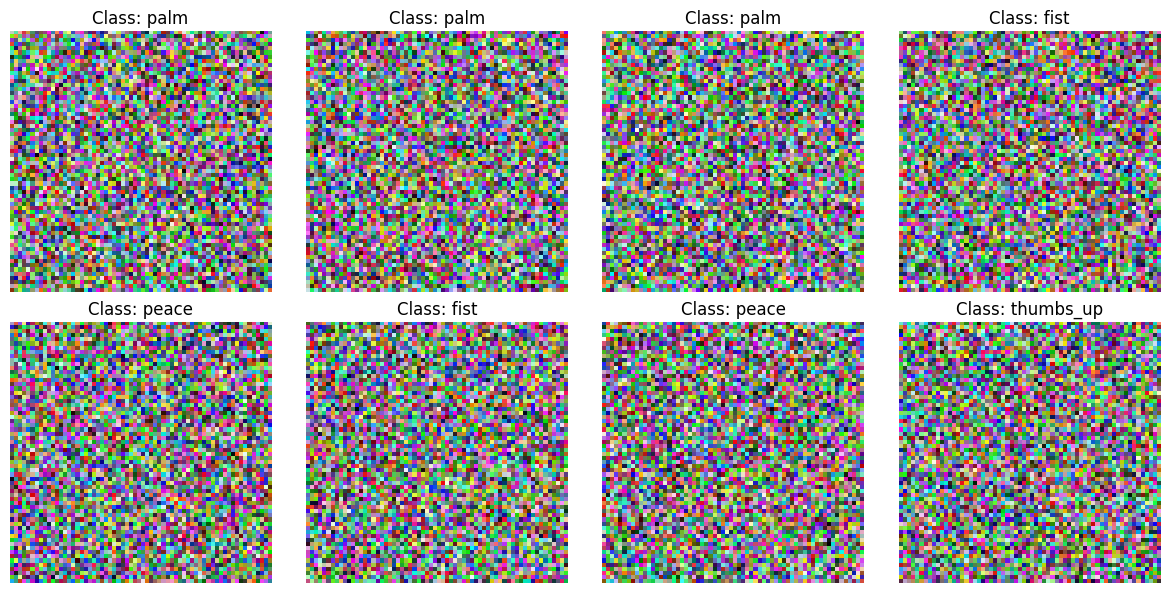

In [10]:
def plot_sample_images(X, y, class_names, n_samples=8):
    """
    Plot sample images from the dataset
    """
    indices = np.random.choice(len(X), n_samples, replace=False)

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        axes[i].imshow(X[idx])
        axes[i].set_title(f'Class: {class_names[y[idx]]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot sample images
plot_sample_images(X_train, y_train, label_encoder.classes_)

In [11]:
def create_gesture_model(input_shape, num_classes):
    """
    Create a CNN model for gesture recognition
    """
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Fourth convolutional block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create the model
model = create_gesture_model((64, 64, 3), n_classes)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,047,749 (4.00 MB)

 Trainable params: 1,046,789 (3.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

print("Training callbacks setup complete!")


Training callbacks setup complete!


In [13]:
print("Training the model...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Training completed!")

Training the model...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 400ms/step - accuracy: 0.2062 - loss: 3.2485 - val_accuracy: 0.1625 - val_loss: 1.8357 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 385ms/step - accuracy: 0.2279 - loss: 2.0495 - val_accuracy: 0.1937 - val_loss: 2.4078 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - accuracy: 0.2045 - loss: 1.7642 - val_accuracy: 0.1937 - val_loss: 2.6533 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 470ms/step - accuracy: 0.2052 - loss: 1.7081 - val_accuracy: 0.1750 - val_loss: 2.4424 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 374ms/step - accuracy: 0.2143 - loss: 1.6996 - val_accuracy: 0.2250 - val_loss: 2.4414 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 392ms/step - accuracy: 0.1856 - loss: 1.6791 - val_accuracy: 0.2250 - val_loss: 2.3555 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 411ms/step - accuracy: 0.2186 - loss: 1.6318 - val_ac

In [14]:
print("Evaluating the model...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

Evaluating the model...
Test Accuracy: 0.1500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step

Classification Report:
              precision    recall  f1-score   support

        fist       0.00      0.00      0.00        40
        palm       0.00      0.00      0.00        44
       peace       0.00      0.00      0.00        42
    pointing       0.16      0.86      0.27        35
   thumbs_up       0.00      0.00      0.00        39

    accuracy                           0.15       200
   macro avg       0.03      0.17      0.05       200
weighted avg       0.03      0.15      0.05       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
def plot_training_history(history):
    """
    Plot training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_sample_predictions(X, y_true, y_pred, class_names, n_samples=8):
    """
    Plot sample predictions
    """
    indices = np.random.choice(len(X), n_samples, replace=False)

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        axes[i].imshow(X[idx])
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        color = 'green' if y_true[idx] == y_pred[idx] else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color=color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


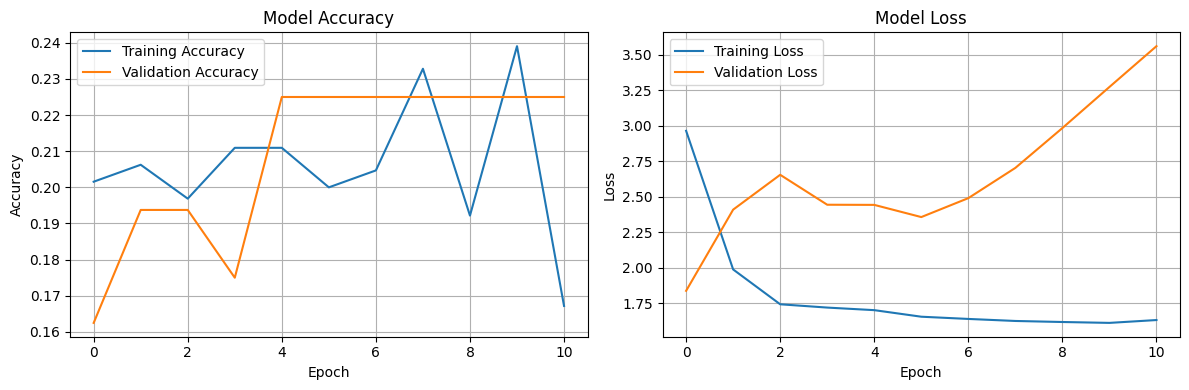

In [16]:
plot_training_history(history)

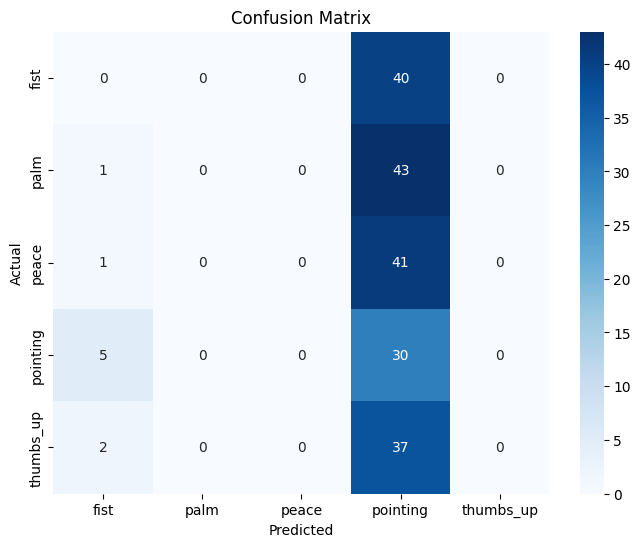

In [18]:
plot_confusion_matrix(y_test, y_pred_classes, label_encoder.classes_)

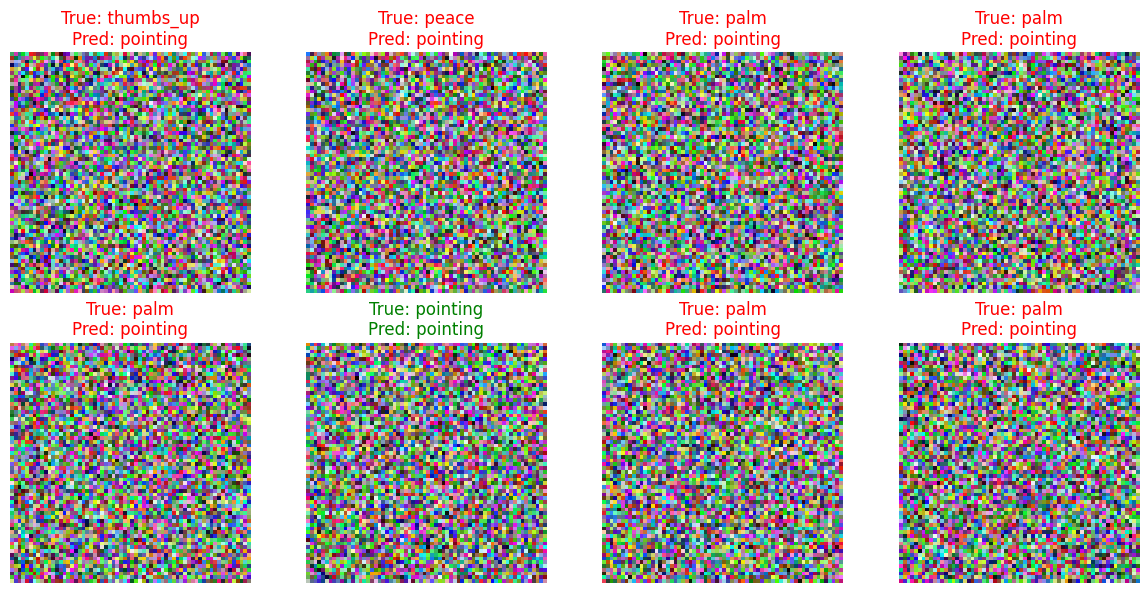

In [19]:
plot_sample_predictions(X_test, y_test, y_pred_classes, label_encoder.classes_)

In [20]:
def predict_gesture(image_path, model, label_encoder, target_size=(64, 64)):
    """
    Predict gesture from a new image
    """
    try:
        # Load and preprocess image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)

        # Make prediction
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)

        gesture_name = label_encoder.classes_[predicted_class]

        return gesture_name, confidence

    except Exception as e:
        print(f"Error predicting gesture: {e}")
        return None, 0

def predict_gesture_from_frame(frame, model, label_encoder, target_size=(64, 64)):
    """
    Predict gesture from video frame
    """
    try:
        # Preprocess frame
        frame_resized = cv2.resize(frame, target_size)
        frame_normalized = frame_resized.astype(np.float32) / 255.0
        frame_batch = np.expand_dims(frame_normalized, axis=0)

        # Make prediction
        prediction = model.predict(frame_batch, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)

        gesture_name = label_encoder.classes_[predicted_class]

        return gesture_name, confidence

    except Exception as e:
        print(f"Error predicting gesture from frame: {e}")
        return None, 0

print("Prediction functions defined!")

Prediction functions defined!


In [21]:
def real_time_gesture_recognition(model, label_encoder):
    """
    Real-time gesture recognition using webcam
    Note: This function requires cv2 and webcam access
    """
    print("Starting real-time gesture recognition...")
    print("Press 'q' to quit")

    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame")
            break

        # Flip frame horizontally for mirror effect
        frame = cv2.flip(frame, 1)

        # Convert BGR to RGB for prediction
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Predict gesture
        gesture, confidence = predict_gesture_from_frame(frame_rgb, model, label_encoder)

        if gesture and confidence > 0.5:  # Only show prediction if confidence > 50%
            # Display prediction on frame
            text = f"{gesture}: {confidence:.2f}"
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Display frame
        cv2.imshow('Gesture Recognition', frame)

        # Break loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

print("Real-time recognition function defined!")

Real-time recognition function defined!


In [22]:
model.save('gesture_recognition_model.h5')
print("Model saved as 'gesture_recognition_model.h5'")

# Save label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Label encoder saved as 'label_encoder.pkl'")

print("\n" + "="*50)
print("GESTURE RECOGNITION MODEL TRAINING COMPLETE!")
print("="*50)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("Model and label encoder saved successfully!")

Model saved as 'gesture_recognition_model.h5'
Label encoder saved as 'label_encoder.pkl'

GESTURE RECOGNITION MODEL TRAINING COMPLETE!
Final Test Accuracy: 0.1500
Model and label encoder saved successfully!


In [23]:
print("\n" + "="*50)
print("USAGE EXAMPLES:")
print("="*50)

print("\n1. For real-time recognition (requires webcam):")
print("real_time_gesture_recognition(model, label_encoder)")

print("\n2. To predict from an image file:")
print("gesture, confidence = predict_gesture('path_to_image.jpg', model, label_encoder)")
print("print(f'Predicted gesture: {gesture} with confidence: {confidence:.2f}')")

print("\n3. To load saved model later:")
print("from tensorflow.keras.models import load_model")
print("import joblib")
print("model = load_model('gesture_recognition_model.h5')")
print("label_encoder = joblib.load('label_encoder.pkl')")

print("\n4. Class names available:")
print("Classes:", label_encoder.classes_)


USAGE EXAMPLES:

1. For real-time recognition (requires webcam):
real_time_gesture_recognition(model, label_encoder)

2. To predict from an image file:
gesture, confidence = predict_gesture('path_to_image.jpg', model, label_encoder)
print(f'Predicted gesture: {gesture} with confidence: {confidence:.2f}')

3. To load saved model later:
from tensorflow.keras.models import load_model
import joblib
model = load_model('gesture_recognition_model.h5')
label_encoder = joblib.load('label_encoder.pkl')

4. Class names available:
Classes: ['fist' 'palm' 'peace' 'pointing' 'thumbs_up']


In [24]:
print("\nTesting with sample images:")
for i in range(3):
    idx = np.random.randint(0, len(X_test))

    # Create a temporary image file
    temp_img = (X_test[idx] * 255).astype(np.uint8)
    cv2.imwrite(f'temp_image_{i}.jpg', cv2.cvtColor(temp_img, cv2.COLOR_RGB2BGR))

    # Predict using our function
    predicted_gesture, confidence = predict_gesture(f'temp_image_{i}.jpg', model, label_encoder)
    actual_gesture = label_encoder.classes_[y_test[idx]]

    print(f"Image {i+1}: Actual: {actual_gesture}, Predicted: {predicted_gesture}, Confidence: {confidence:.3f}")

    # Clean up temp file
    os.remove(f'temp_image_{i}.jpg')

print("\nModel is ready for use!")


Testing with sample images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Image 1: Actual: peace, Predicted: pointing, Confidence: 0.313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Image 2: Actual: palm, Predicted: pointing, Confidence: 0.315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Image 3: Actual: pointing, Predicted: pointing, Confidence: 0.314

Model is ready for use!
